<a href="https://colab.research.google.com/github/stefan-gietl/heat-exchangers/blob/main/3_Temperaturabhaengige_Stoffwerte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zellmethodik

- 1 Imports
- 2 Wiederholung: Zellmethodik
- 3 Temperaturabhängige Stoffdaten mit Zellmethodik

## 1 Imports

In [12]:
!pip install pyfluids
from CoolProp.CoolProp import PropsSI
import math

## 2 Wiederholung: Zellmethodik
Nachbau der Excel "ZELLENMODELL_We2025.xlsx"
- Zellwirkungsgrade: $\epsilon_1 = \epsilon_2 = 0.25$
- Eintrittstemperaturen: $T_{G,ein} = 1000$ °C, $T_{F,ein}= 0$ °C
- Anordnung:

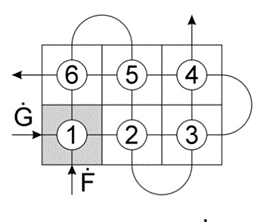

In [5]:
# Eintrittstemperaturen
TGein = 1000  # °C
TFein = 0  # °C

# Zellwirkungsgrade
eps1 = 0.25
eps2 = 0.25

# Leere Listen für Zell-Austrittstemperaturen vorbereiten
n_zellen = 6
TG = [0] * 6
TF = [0] * 6

# Methode für Zelle nach Excel-Vorlage
def ExcelZelle(epsilon1, epsilon2, T1ein, T2ein):
  T1aus = (1 - epsilon1) * T1ein + epsilon1 * T2ein
  T2aus = (1 - epsilon2) * T2ein + epsilon2 * T1ein
  return T1aus, T2aus

# Iterative Lösung der Zellmethodik
for _ in range(1000):
  TG[0], TF[0] = ExcelZelle(eps1, eps2, TGein, TFein)
  TG[1], TF[1] = ExcelZelle(eps1, eps2, TG[0], TF[4])
  TG[2], TF[2] = ExcelZelle(eps1, eps2, TG[1], TF[1])
  TG[3], TF[3] = ExcelZelle(eps1, eps2, TG[2], TF[2])
  TG[4], TF[4] = ExcelZelle(eps1, eps2, TG[3], TF[5])
  TG[5], TF[5] = ExcelZelle(eps1, eps2, TG[4], TF[0])

# Ausgabe der Austrittstemperaturen
print(f"Austrittstemperaturen sind:  {TG[5]:.1f} °C und {TF[3]:.1f} °C.")
print(f"Temperaturen aus Excel sind: 454.5 °C und 545.5 °C.")

Austrittstemperaturen sind:  454.5 °C und 545.5 °C.
Temperaturen aus Excel sind: 454.5 °C und 545.5 °C.


## 3 Temperaturabhängige Stoffdaten mit Zellmethodik
Temperaturabhängige Stoffdaten in Zielwert kA Bestimmung durch Anwendung der Zellmethodik
- Eintrittstemperaturen: $T_{ein,Heiss} = 450$ °C, $T_{ein,Kalt} = 25$ °C
- Normvolumenströme: $V_{N,Heiss} = 559$ Nm³/h, $V_{N,Kalt} = 854$ Nm³/h
- Soll-Austrittstemperaturen: $T_{aus,Heiss,Soll} = 113$ °C, $T_{aus,Kalt,Soll} = 250$ °C
- Druckniveaus: $p_{Heiss} = p_{Kalt} = 101575$ Pa
- Fläche: $A = 30$ m²
---
- Startwerte für die Iteration: $T_{aus,Heiss} = T_{aus,Kalt} = 200$ °C, $k = 12$ W/m²K


In [11]:
# Vorgaben
Tein_Heiss = 450  # °C
Tein_Kalt = 25  # °C
V_N_Heiss = 559  # Nm³/h
V_N_Kalt = 854  # Nm³/h
Taus_Heiss_Soll = 113
Taus_Kalt_Soll = 250

# Pressure Conditions
Druck_Heiss = 101575  # Pa
Druck_Kalt = 101575  # Pa

# Initial Guess
k = 12  # W/m²K

A = 30  # m²

# Anzahl der Zellen
n = 5


class Zelle():
  def __init__(self, area, V_N_Heiss, V_N_Kalt, Druck_Heiss, Druck_Kalt):
    self.area = area
    self.V_N_Heiss = V_N_Heiss
    self.V_N_Kalt = V_N_Kalt
    self.Druck_Heiss = Druck_Heiss
    self.Druck_Kalt = Druck_Kalt
    self.Taus_Heiss = 200
    self.Taus_Kalt = 200
    self.rho_norm = PropsSI("D", "T", 273.15, "P", 101325, "AIR")

  def __call__(self, k, Tein_Heiss, Tein_Kalt):
    Tmittel_Heiss = (Tein_Heiss + self.Taus_Heiss) / 2
    Tmittel_Kalt = (Tein_Kalt + self.Taus_Kalt) / 2
    cp1 = PropsSI("C", "T", (Tmittel_Heiss+273.15), "P", self.Druck_Heiss, "AIR")
    cp2 = PropsSI("C", "T", (Tmittel_Kalt+273.15), "P", self.Druck_Kalt, "AIR")
    NTU1 = k * self.area / (cp1 * self.rho_norm * self.V_N_Heiss / 3600)
    NTU2 = k * self.area / (cp2 * self.rho_norm * self.V_N_Kalt / 3600)
    R1 = cp1 * self.V_N_Heiss / (cp2 * self.V_N_Kalt)
    R2 = 1 / R1
    eps1 = (1 - math.exp((R1 - 1) * NTU1)) / (1 - R1 * math.exp((R1 - 1) * NTU1))
    eps2 = (1 - math.exp((R2 - 1) * NTU2)) / (1 - R2 * math.exp((R2 - 1) * NTU2))
    self.Taus_Heiss = (1 - eps1) * Tein_Heiss + eps1 * Tein_Kalt
    self.Taus_Kalt = (1 - eps2) * Tein_Kalt + eps2 * Tein_Heiss
    return self.Taus_Heiss, self.Taus_Kalt

# Leere Listen für Zell-Austrittstemperaturen vorbereiten
TG = [0] * n
TF = [0] * n

# Initialisieren der Zellen
cell_area = A/n
Zellen = [Zelle(cell_area, V_N_Heiss, V_N_Kalt, Druck_Heiss, Druck_Kalt) for _ in range(n)]

# Iterative Lösung mit Zellmethodik
error = 1.0
while abs(error) > 0.0001:
  TG[0], TF[0] = Zellen[0](k, Tein_Heiss, TF[1])
  for i in range(n - 2):
    TG[i+1], TF[i+1] = Zellen[i+1](k, TG[i], TF[i+2])
  TG[n-1], TF[n-1] = Zellen[n-1](k, TG[n-2], Tein_Kalt)
  error = Taus_Heiss_Soll - TG[n-1]
  k -= 0.01 * error

# Ausgabe
print(f"k= {k:.4f} W/m²K")

k= 17.1360 W/m²K
